In [1]:
%pylab 
%matplotlib inline
import sympy
from control.matlab import *
from sympy import Poly
from sympy.abc import s, z
from IPython.display import display,Latex,Math

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


<div id="toc"></div>

# Aircraft Pitch: Frequency Domain Methods for Controller Design

From the main problem, the open-loop transfer function for the aircraft pitch dynamics is

$$
P(s) = \frac{\Theta(s)}{\Delta(s)} = \frac {1.151s+0.1774}{s^3+0.739s^2+0.921s}
$$

where the input is elevator deflection angle \\(\delta\\) and the output is the aircraft pitch angle $\theta$. For the original problem setup and the derivation of the above transfer function please refer to the [Aircraft Pitch: System Modeling](../AircraftPitch/AircraftPitch-SystemModeling.ipynb) page For a step reference of 0.2 radians, the design criteria are the following.
* Overshoot less than 10
* Rise time less than 2 seconds
* Settling time less than 10 seconds
* Steady-state error less than 2

## Open-loop response

Let's first begin by examining the behavior of the open-loop plant. Specifically, create a new [m-file](../Extras_Mfile.ipynb), and enter the following commands. Note the scaling of the step response by 0.2 to account for the fact that the input is a step of 0.2 radians (11 degrees). Running this m-file in the MATLAB command window should give you the step response plot shown below.

In [2]:
# Helper Functions
def tex(eqn):
    # Quick way to display a symbolic equation.
    display(Math(sympy.latex(eqn)))
def sym_to_tf(sym_sys):
    # Convert symbolic equation into a transfer function.
    sym_num=sympy.Poly(sympy.numer(sym_sys))
    sym_den=sympy.Poly(sympy.denom(sym_sys))
    num = float64(sym_num.all_coeffs())
    den = float64(sym_den.all_coeffs())
    sys = tf(num,den)
    return sys

<IPython.core.display.Math object>

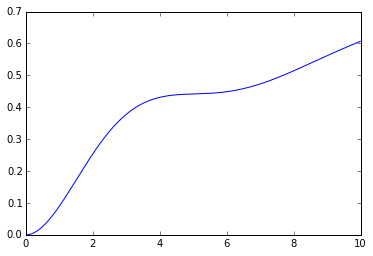

In [4]:
t = np.arange(0,10,0.01)
P_pitch = (1.151*s + 0.1774)/(s**3 + 0.739*s**2 + 0.921*s);
tex(P_pitch)
P_pitch=sym_to_tf(P_pitch)
y,t = step(0.2*P_pitch,t);
plt.plot(t,y)
# axis([0 10 0 0.8]);
# ylabel('pitch angle (rad)');
# title('Open-loop Step Response');
# grid

Examination of the above plot indicates that the open-loop system is unstable for a step input, that is, its output grows unbounded when given a step input. This is due to the fact that the transfer function has a pole at the origin.

## Closed-loop response

Let's now close the loop on our plant and see if that stabilizes the system. Consider the following unity feedback architecture for our system.
![feedback_pitch2.png](figures/feedback_pitch2.png)
The following code entered in the MATLAB command window generates the closed-loop transfer function assuming the unity-feedback architecture above and a unity-gain controller, _C_(_s_) = 1.

In [5]:
sys_cl = feedback(P_pitch,1)

Examining the poles of this transfer function using the |pole| command as shown below, it can be seen that this closed-loop system is indeed stable since all of the poles have negative real part.

In [6]:
pole(sys_cl)

array([-0.32547320+1.38157483j, -0.32547320-1.38157483j, -0.08805361+0.j        ])

Stability of this closed-loop system can also be determined using the frequency response of the open-loop system. The |margin| command generates the Bode plot for the given transfer function with annotations for the gain margin and phase margin of the system when the loop is closed as demonstrated below.

In [7]:
margin(P_pitch)

(None, 46.911641882363796, 1.2668918351869958, None)

Examination of the above demonstrates that the closed-loop system is indeed stable since the phase margin and gain margin are both positive. Specifically, the phase margin equals 46.9 degrees and the gain margin is infinite. It is good that this closed-loop system is stable, but does it meet our requirements? Add the following code to your m-file and re-run and you will generate the step response plot shown below.

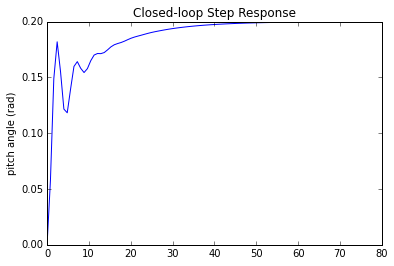

In [8]:
sys_cl = feedback(P_pitch,1);
y, t = step(0.2*sys_cl)
plt.plot(t,y)
# step(0.2*sys_cl), grid
ylabel('pitch angle (rad)');
title('Closed-loop Step Response')

Examination of the above demonstrates that the settle time requirement of 10 seconds is not close to being met. One way to address this is to make the system response faster, but then the overshoot shown above will likely become a problem. Therefore, the overshoot must be reduced in conjunction with making the system response faster. We can accomplish these goals by adding a compensator to reshape the Bode plot of the open-loop system. The Bode plot of the open-loop system indicates behavior of the closed-loop system. More specifically,
* the gain crossover frequency is directly related to the closed-loop system's speed of response, and
* the phase margin is inversely related to the closed-loop system's overshoot. Therefore, we need to add a compensator that will increase the gain crossover frequency and increase the phase margin as indicated in the Bode plot of the open-loop system.

## Lead compensator

A type of compensator that can accomplish both of our goals is a lead compensator. Referring to the [Compensators](../Extras_Leadlag Lead and Lag.ipynb) page, a lead compensator adds positive phase to the system. Additional positive phase increases the phase margin, thus, increasing the damping. The lead compensator also generally increases the magnitude of the open-loop frequency response at higher frequencies, thereby, increasing the gain crossover frequency and overall speed of the system. Therefore, the settling time should decrease as a result of the addition of a lead compensator. The general form of the transfer function of a lead compensator is the following.

$$
C(s)=K \frac{Ts + 1}{\alpha Ts+1} \ \ \ (\alpha < 1)
$$

We thus need to find $\alpha$, _T_ and _K_. Typically, the gain _K_ is set to satisfy requirements on steady-state error. Since our system is already type 1 (the plant has an integrator) the steady-state error for a step input will be zero for any value of _K_. Even though the steady-state error is zero, the slow tail on the response can be attributed to the fact the velocity-error constant is too small. This deficiency can be addressed by employing a value of _K_ that is greater than 1, in other words, a value of _K_ that will shift the magnitude plot upward. Through some trial and error, we will somewhat arbitrarily choose _K_ = 10. Running the following code in the MATLAB window will demonstrate the effect of adding this _K_.

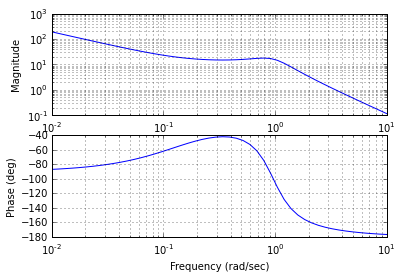

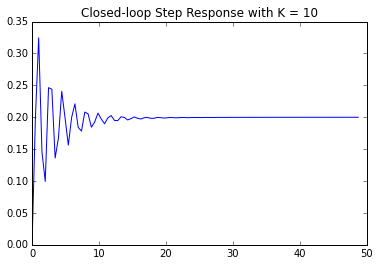

In [9]:
K = 10
margin(K*P_pitch)
mag, phase, omega = bode(K*P_pitch, Plot=True)
sys_cl = feedback(K*P_pitch,1);
plt.figure()
y, t = step(0.2*sys_cl)
plot(t,y)
title('Closed-loop Step Response with K = 10')

From examination of the above Bode plot, we have increased the system's magnitude at all frequencies and have pushed the gain crossover frequency higher. The effect of these changes are evident in the closed-loop step response shown above. Unfortunately, the addition of the _K_ has also reduced the system's phase margin as evidenced by the increased overshoot in the system's step response. As mentioned previously, the lead compensator will help add damping to the system in order to reduce the overshoot in the step response. Continuing with the design of our compensator, we will next address the parameter \\(\alpha\\) which is defined as the ratio between the zero and pole. The larger the separation between the zero and the pole the greater the bump in phase where the maximum amount of phase that can be added with a single pole-zero pair is 90 degrees. The following equation captures the maximum phase added by a lead compensator as a function of $\alpha$.

$$
\sin(\phi_m)=\frac{1 - \alpha}{1 + \alpha}
$$

Relationships between the time response and frequency response of a standard underdamped second-order system can be derived. One such relationship that is a good approximation for damping ratios less than approximately 0.6 or 0.7 is the following.

$$
\zeta \approx \frac{PM (degrees)}{100^{\circ}}
$$

While our system does not have the form of a standard second-order system, we can use the above relationship as a starting point in our design. As we are required to have overshoot less than 10%, we need our damping ratio \\(\zeta\\) to be approximately larger than 0.59 and thus need a phase margin greater than about 59 degrees. Since our current phase margin (with the addition of _K_) is approximately 10.4 degrees, an additional 50 degrees of phase bump from the lead compensator should be sufficient. Since it is known that the lead compensator will further increase the magnitude of the frequency response, we will need to add more than 50 degrees of phase lead to account for the fact that the gain crossover frequency will increase to a point where the system has more phase lag. We will somewhat arbitrarily add 5 degrees and aim for a total bump in phase of 50+5 = 55 degrees. We can then use this number to solve the above relationship for \\(\alpha\\) as shown below.

$$
\alpha = \frac{1 - \sin(55^{\circ})}{1 + \sin(55^{\circ})} \approx 0.10
$$

From the above, we can calculate that \\(\alpha\\) must be less than approximately 0.10. For this value of $\alpha$, the following relationship can be used to determine the amount of magnitude increase that will be supplied by the lead compensator at the location of the maximum bump in phase.

$$
20 \log \left( \frac{1}{\sqrt{\alpha}} \right) \approx 20 \log \left( \frac{1}{\sqrt{0.10}} \right) \approx 10 dB
$$

Examining the Bode plot shown above, the magnitude of the uncompensated system equals -10 dB at approximately 6.1 rad/sec. Therefore, the addition of our lead compensator will move the gain crossover frequency from 3.49 rad/sec to approximately 6.1 rad/sec. Using this information, we can then calculate a value of _T_ from the following in order to center the maximum bump in phase at the new gain crossover frequency in order to maximize the system's resulting phase margin.

$$
\omega_m = \frac{1}{T \sqrt{\alpha}} \Rightarrow T = \frac{1}{6.1\sqrt{.10}} \approx 0.52
$$

With the values _K_ = 10, \\(\alpha\\) = 0.10, and _T_ = 0.52 calculated above, we now have a first attempt at our lead compensator. Adding the following lines to your m-file and running at the command line will generate the plot shown below demonstrating the effect of your lead compensator on the system's frequency response.

<IPython.core.display.Math object>

(None, 60.545846382951567, 6.0908274418242003, None)

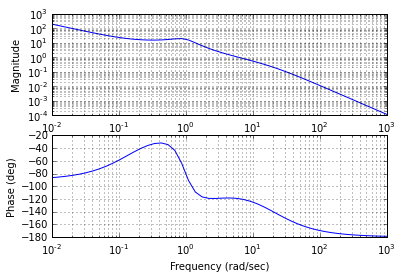

In [10]:
K = 10
alpha = 0.10
T = 0.52
C_lead = K*(T*s + 1) / (alpha*T*s + 1)
tex(C_lead)
C_lead = sym_to_tf(C_lead)
display(margin(C_lead*P_pitch))
mag, phase, omega = bode(C_lead*P_pitch, Plot=True)

Examination of the above demonstrates that the lead compensator increased the system's phase margin and gain crossover frequency as desired. We now need to look at the actual closed-loop step response in order to determine if we are close to meeting our requirements. Replace the step response code in your m-file with the following and re-run in the MATLAB command window.

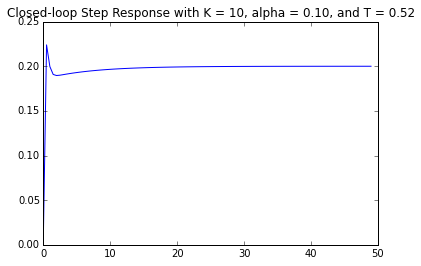

In [11]:
sys_cl = feedback(C_lead*P_pitch,1);
y, t = step(0.2*sys_cl)
plot(t,y)
title('Closed-loop Step Response with K = 10, alpha = 0.10, and T = 0.52')

From the above, all of our requirements are met except for the overshoot which is a bit larger than the requirement of 10%. Iterating on the above design process, we arrive at the parameters _K_ = 10, \\(\alpha\\) = 0.04, and _T_ = 0.55. The performance achieved with this controller can then be verified by modifying the code in your m-file as follows.

<IPython.core.display.Math object>

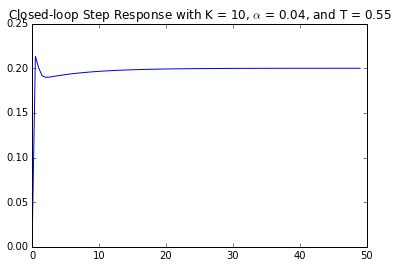

In [12]:
K = 10
alpha = 0.04
T = 0.55

C_lead = K*(T*s + 1) / (alpha*T*s + 1)
tex(C_lead)
C_lead = sym_to_tf(C_lead)
sys_cl = feedback(C_lead*P_pitch,1)
y,t = step(0.2*sys_cl)
plot(t,y)
title('Closed-loop Step Response with K = 10, $\\alpha$ = 0.04, and T = 0.55')

In [13]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>